In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from seaborn import objects as so

In [2]:
device = (
    "cuda"
    if torch.cuda.is_available()
    else "mps"
    if torch.backends.mps.is_available()
    else "cpu"
)
print(f"Using {device}")

Using mps


In [3]:
training_data = datasets.FashionMNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor(),
)

test_data = datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor(),
)

classes = [
    "T-shirt/top",
    "Trouser",
    "Pullover",
    "Dress",
    "Coat",
    "Sandal",
    "Shirt",
    "Sneaker",
    "Bag",
    "Ankle boot",
]

In [4]:
batch_size = 64

train_dataloader = DataLoader(training_data, batch_size=batch_size)
test_dataloader = DataLoader(test_data, batch_size=batch_size)

for X, y in test_dataloader:
    print(f"Shape of X [N, C, H, W]: {X.shape}")
    print(f"Shape of y: {y.shape} {y.dtype}")
    break

Shape of X [N, C, H, W]: torch.Size([64, 1, 28, 28])
Shape of y: torch.Size([64]) torch.int64


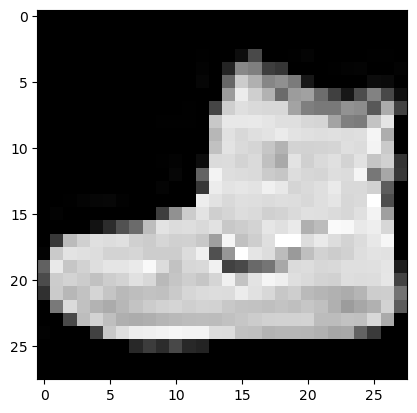

In [5]:
plt.imshow(train_dataloader.dataset[0][0].squeeze(0), cmap=plt.get_cmap('gray'))

In [6]:
train_dataloader.dataset[0][0][0, 24, :]*255

tensor([  2.,   0.,   0.,   0.,  66., 200., 222., 237., 239., 242., 246., 243.,
        244., 221., 220., 193., 191., 179., 182., 182., 181., 176., 166., 168.,
         99.,  58.,   0.,   0.])

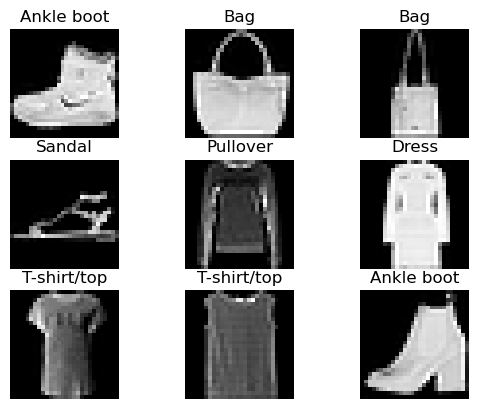

In [7]:
for i in range(9):
    plt.subplot(3, 3, 1 + i)
    img = train_dataloader.dataset[i*100][0].squeeze(0)
    plt.title(classes[train_dataloader.dataset[i*100][1]])
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.axis('off')

In [8]:
train_dataloader.dataset[0][0].shape

torch.Size([1, 28, 28])

In [5]:
class NeuralNetwork(nn.Module):
    def __init__(self):
        super().__init__()
        self.flatten = nn.Flatten()
        self.linear1 = nn.Linear(28 * 28, 512)
        self.relu1 = nn.ReLU()
        self.stack = nn.Sequential(
            nn.BatchNorm1d(512),
            nn.Linear(512, 512, bias=False),
            nn.ReLU(),
            nn.BatchNorm1d(512),
            nn.Linear(512, 10, bias=False)
            # nn.Softmax(dim=1) # for probabilities 
        )

    def forward(self, x):
        x = self.flatten(x)
        x = self.linear1(x)
        x = self.relu1(x)
        # ... use this for more options, residual connections etc.
        logits = self.stack(x)
        return logits


model = NeuralNetwork().to(device)
print(model)

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (stack): Sequential(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=512, out_features=512, bias=False)
    (2): ReLU()
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=512, out_features=10, bias=False)
  )
)


In [10]:
with torch.no_grad():
    model.eval()
    prediction = model(train_dataloader.dataset[0][0].to(device))
    print(f"Prediction: {prediction}")
    print(f"Predicted class: {prediction.argmax()}")

Prediction: tensor([[ 0.0808, -0.0169,  0.0522,  0.0729,  0.0493, -0.0240,  0.0464,  0.0077,
         -0.0529,  0.0792]], device='mps:0')
Predicted class: 0


In [11]:
def train_loop(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.train()
    running_loss = 0

    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction and loss
        pred = model(X)
        loss = loss_fn(pred, y)
        running_loss += loss.item()

        # Backpropagation
        loss.backward()
        optimizer.step()
        optimizer.zero_grad()

        if batch % 100 == 0:
            loss, current = loss.item(), (batch + 1) * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")

    return running_loss / num_batches


def test_loop(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval()
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item()

    test_loss /= num_batches
    accuracy = correct / size
    return test_loss, accuracy

loss: 2.469336  [   64/60000]
loss: 0.485016  [ 6464/60000]
loss: 0.397458  [12864/60000]
loss: 0.574445  [19264/60000]
loss: 0.487151  [25664/60000]
loss: 0.383125  [32064/60000]
loss: 0.354271  [38464/60000]
loss: 0.564965  [44864/60000]
loss: 0.513261  [51264/60000]
loss: 0.456129  [57664/60000]
Epoch 0
-------------------------------
Training_loss: 0.4609121436884662
Test_loss: 0.4502092676747377
Accuracy: 0.8353

loss: 0.329666  [   64/60000]
loss: 0.372039  [ 6464/60000]
loss: 0.319007  [12864/60000]
loss: 0.357778  [19264/60000]
loss: 0.439793  [25664/60000]
loss: 0.337143  [32064/60000]
loss: 0.284908  [38464/60000]
loss: 0.421829  [44864/60000]
loss: 0.406751  [51264/60000]
loss: 0.418943  [57664/60000]
loss: 0.292980  [   64/60000]
loss: 0.362176  [ 6464/60000]
loss: 0.304699  [12864/60000]
loss: 0.341657  [19264/60000]
loss: 0.356055  [25664/60000]
loss: 0.338171  [32064/60000]
loss: 0.281500  [38464/60000]
loss: 0.369898  [44864/60000]
loss: 0.331191  [51264/60000]
loss: 0.

<Axes: >

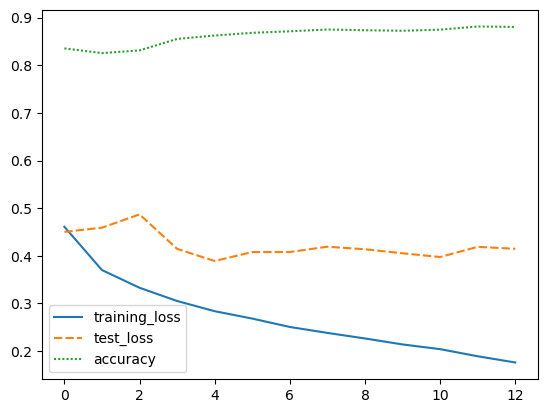

In [12]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
metrics = {'training_loss': [], 'test_loss': [], 'accuracy': []}


def no_progress(metric_history, delta, patience=10):
    if len(metric_history) < patience:
        return False
    last_entries = metric_history[-patience:]
    return max(last_entries) - min(last_entries) < delta


for t in range(100):
    training_loss = train_loop(train_dataloader, model, loss_fn, optimizer)
    metrics['training_loss'].append(training_loss)
    test_loss, accuracy = test_loop(test_dataloader, model, loss_fn)
    metrics['test_loss'].append(test_loss)
    metrics['accuracy'].append(accuracy)
    if no_progress(metrics['accuracy'], delta=0.03):
        print('No progress, aborting')
        break
    if t % 10 == 0:
        print(f"Epoch {t}\n-------------------------------")
        print(f'Training_loss: {training_loss}')
        print(f'Test_loss: {test_loss}')
        print(f'Accuracy: {accuracy}')
        print()

sns.lineplot(data=metrics)

In [31]:
with torch.no_grad():
    prediction = model(train_dataloader.dataset[0][0].to(device))
    print(f"Logits: {prediction}") # logits in [-inf, inf], sum ?
    print(f"Predicted class: {prediction.argmax()}")
    print(f"Probabilities: {[float(f'{p:.3f}') for p in nn.Softmax(1)(prediction).squeeze().tolist()]}") # probabilities in [0, 1], sum = 1

Logits: tensor([[-6.2158, -2.1085, -1.5725, -0.9767, -1.0116, -3.4960, -2.6668,  7.1899,
         -7.3917, 14.3011]], device='mps:0')
Predicted class: 9
Probabilities: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.001, 0.0, 0.999]


## Softmax

* $\sum(logits) \ne 1 \implies $ keine Wahrscheinlichkeiten
* Softmax(logits) $\rightarrow$ Probabilities
![](./assets/softmax.webp)
* Inputs $$\mathbf{z} = (z_1, \dotsc, z_K) \in R^K$$
  $$\sigma(\mathbf{z})_i = \frac{e^{z_i}}{\sum_{j=1}^K e^{z_j}}$$

## Temperature
* Temperature gleicht Werte aus, je höher T umso randomer, GPT: $[0, 2]$
![](./assets/temperature.png)
![](./assets/softmax.gif)

[![](./assets/3blue-1brown.png)](https://www.youtube.com/watch?v=wjZofJX0v4M&t=1342s)

In [99]:
def plot_softmax(temp=1):
    with torch.no_grad():
        prediction = model(test_dataloader.dataset[9275][0].to(device))
        return (so.Plot()
                .add(so.Bars(), x=range(10), y=nn.Softmax(1)(prediction/temp).to('cpu').squeeze())
                .label(x='', y='')
                )

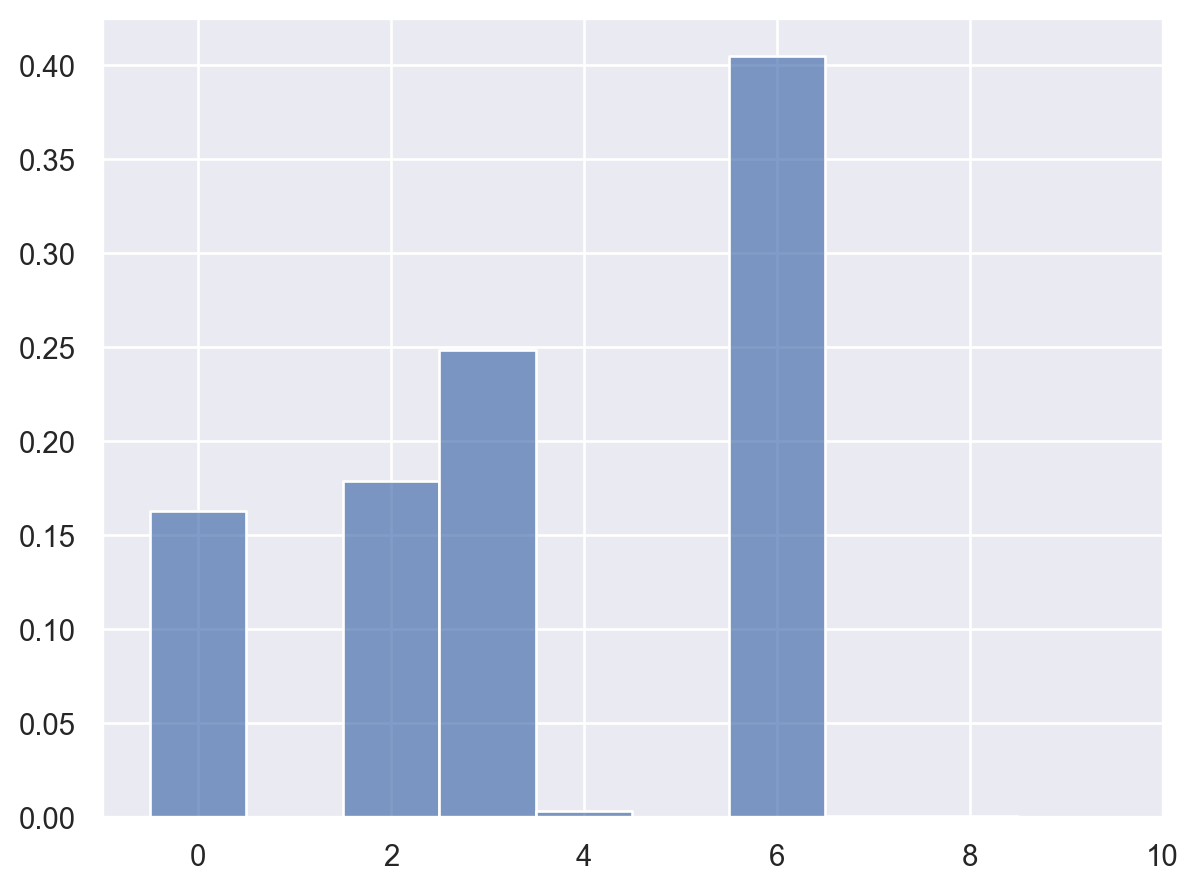

In [100]:
plot_softmax(1)

## Speichern/Laden eines trainierten Models

In [15]:
path = './models/mnist-fashion-model.pt'
torch.save(model.state_dict(), path)

In [16]:
model = NeuralNetwork()
model.load_state_dict(torch.load(path))
model.eval()

NeuralNetwork(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear1): Linear(in_features=784, out_features=512, bias=True)
  (relu1): ReLU()
  (stack): Sequential(
    (0): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (1): Linear(in_features=512, out_features=512, bias=False)
    (2): ReLU()
    (3): BatchNorm1d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (4): Linear(in_features=512, out_features=10, bias=False)
  )
)

In [32]:
model.to(device)
with torch.no_grad():
    prediction = model(train_dataloader.dataset[1337][0].to(device))
    print(f"Logits: {prediction}") # logits in [-inf, inf], sum ?
    print(f"Predicted class: {prediction.argmax()}")
    print(f"Probabilities: {nn.Softmax(1)(prediction)}") # probabilities in [0, 1], sum = 1

Logits: tensor([[-5.7056, -4.7100,  0.1220, -3.5993, -4.3044, 13.1789, -8.7525,  9.7800,
         -1.9066, -2.2826]], device='mps:0')
Predicted class: 5
Probabilities: tensor([[6.0853e-09, 1.6469e-08, 2.0661e-06, 5.0009e-08, 2.4706e-08, 9.6767e-01,
         2.8908e-10, 3.2330e-02, 2.7174e-07, 1.8659e-07]], device='mps:0')
